# Compute Raman activity (RASCBEC-style) for E0.05 and E0.1

Computes **mode-resolved Raman activity** using a RASCBEC-style workflow:

- Born effective charge (BEC) tensors are parsed from **VASP OUTCAR** files for ±E along x, y, z.
- Central finite-difference derivatives \(\partial Z^*/\partial E\) are constructed.
- Derivatives are projected onto **Phonopy eigenvectors** to obtain per-mode Raman activities.

Repository layout assumed:

- `../data/phonopy/POSCAR` (reference structure used for phonopy; defines atom ordering)
- `../data/phonopy/freqs_phonopy.dat`
- `../data/phonopy/eigvecs_phonopy.dat`
- `../data/bec_runs/E0.05/{1,m1,x,mx,y,my,z,mz}/OUTCAR`
- `../data/bec_runs/E0.1/{1,m1,x,mx,y,my,z,mz}/OUTCAR`

Outputs are written to `../data/processed/`.

In [19]:
import numpy as np
from pathlib import Path
import pandas as pd

# Repo paths (running from notebooks/)
POSCAR       = Path("../data/phonopy/POSCAR")
FREQS_FILE   = Path("../data/phonopy/freqs_phonopy.dat")
EIGVECS_FILE = Path("../data/phonopy/eigvecs_phonopy.dat")
BEC_ROOT     = Path("../data/bec_runs")
OUT_DIR      = Path("../data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Two datasets
FIELDS = {"E0.05": 0.05, "E0.1": 0.1}
LABELS = ["1","m1","x","mx","y","my","z","mz"]

# Output
OUT_FILE = OUT_DIR / "raman_phonopy_E0.05_E0.1.dat"

# Units
THZ_TO_CM1 = 33.35640951981521

# C60: single species carbon
ATOMIC_MASS_C = 12.011


In [20]:
missing = [str(p) for p in [POSCAR, FREQS_FILE, EIGVECS_FILE] if not p.exists()]
if missing:
    raise FileNotFoundError("Missing required phonopy inputs:\n" + "\n".join(missing))

missing_outcars = []
for fk in FIELDS:
    for lab in LABELS:
        p = BEC_ROOT / fk / lab / "OUTCAR"
        if not p.exists():
            missing_outcars.append(str(p))

if missing_outcars:
    raise FileNotFoundError("Missing required OUTCAR files:\n" + "\n".join(missing_outcars))

print("All required inputs exist.")


All required inputs exist.


In [22]:
def nat_from_poscar_vasp5(poscar_path: Path) -> int:
    """
    Minimal VASP5 POSCAR atom-count parser.
    Rui's script reads counts from the counts line.
    """
    lines = [l.strip() for l in poscar_path.read_text().splitlines() if l.strip()]
    if len(lines) < 8:
        raise ValueError(f"POSCAR too short: {poscar_path}")
    counts = [int(x) for x in lines[6].split()]  # VASP5 counts line
    return int(sum(counts))

nat = nat_from_poscar_vasp5(POSCAR)
modes = 3 * nat
print("nat =", nat, "modes =", modes)
freqs_thz = np.loadtxt(FREQS_FILE)
eigvecs = np.loadtxt(EIGVECS_FILE)

if freqs_thz.ndim != 1 or len(freqs_thz) != modes:
    raise ValueError(f"freqs_phonopy.dat must be 1D length {modes}; got {freqs_thz.shape}")

# Rui expects eigvecs as 3N x 3N and uses eigvecs[:, s]
# If transposed, fix it.
if eigvecs.shape != (modes, modes):
    if eigvecs.T.shape == (modes, modes):
        eigvecs = eigvecs.T
    else:
        raise ValueError(f"eigvecs_phonopy.dat must be shape {(modes, modes)}; got {eigvecs.shape}")

freqs_cm1 = freqs_thz * THZ_TO_CM1
print("Loaded freqs:", freqs_thz.shape, "eigvecs:", eigvecs.shape)


nat = 60 modes = 180
Loaded freqs: (180,) eigvecs: (180, 180)


In [12]:
freqs_thz = np.loadtxt(FREQS_FILE)
eigvecs = np.loadtxt(EIGVECS_FILE)

# Frequency checks
if freqs_thz.ndim != 1:
    raise ValueError(f"freqs_phonopy.dat expected 1D array, got shape {freqs_thz.shape}")
if len(freqs_thz) != modes_expected:
    raise ValueError(f"Frequency length mismatch: got {len(freqs_thz)} but expected {modes_expected} (=3N)")

# Eigenvector checks
if eigvecs.ndim != 2:
    raise ValueError(f"eigvecs_phonopy.dat expected 2D array, got shape {eigvecs.shape}")

# Common formats: (3N, 3N) or (3N, modes) where modes=3N anyway for Γ-point phonons.
# Ensure final shape is (3N, 3N)
if eigvecs.shape != (modes_expected, modes_expected):
    # If a transposed format was written, fix it
    if eigvecs.T.shape == (modes_expected, modes_expected):
        eigvecs = eigvecs.T
    else:
        raise ValueError(
            f"Eigenvector matrix shape mismatch: got {eigvecs.shape}, expected {(modes_expected, modes_expected)}"
        )

# Convert to cm^-1 for reporting
freqs_cm1 = freqs_thz * THZ_TO_CM1

print("Loaded freqs_thz:", freqs_thz.shape)
print("Loaded eigvecs:", eigvecs.shape)
print("Frequency range (THz):", float(freqs_thz.min()), "to", float(freqs_thz.max()))


Loaded freqs_thz: (180,)
Loaded eigvecs: (180, 180)
Frequency range (THz): -0.09769165941459342 to 46.674657166401495


In [23]:
def read_bec_from_outcar(path: Path, nat: int) -> np.ndarray:
    """
    Return Z* tensor: (nat, 3, 3)

    Matches the original notebook/Rui-style line stepping:
    - find first 'BORN EFFECTIVE CHARGES' occurrence
    - start at i+2
    - per atom: skip ion line, then read 3 tensor rows
    """
    bec = np.zeros((nat, 3, 3), dtype=float)
    lines = path.read_text(errors="ignore").splitlines()

    found = False
    for i, line in enumerate(lines):
        if "BORN EFFECTIVE CHARGES" in line:
            idx = i + 2
            for a in range(nat):
                idx += 1  # ion line
                for d in range(3):
                    # row format: row_index  val  val  val
                    bec[a, d, :] = np.fromstring(lines[idx], sep=" ")[1:4]
                    idx += 1
            found = True
            break

    if not found:
        raise ValueError(f"No 'BORN EFFECTIVE CHARGES' block found in {path}")

    if not np.isfinite(bec).all():
        raise ValueError(f"Non-finite values in parsed BEC from {path}")

    return bec

# Quick sanity check on one file
test_outcar = BEC_ROOT / "E0.05" / "1" / "OUTCAR"
Ztest = read_bec_from_outcar(test_outcar, nat)
print("Parsed BEC shape:", Ztest.shape, "from", test_outcar)


Parsed BEC shape: (60, 3, 3) from ../data/bec_runs/E0.05/1/OUTCAR


In [25]:
def charge_derivative_one_atom(Z1, Zm1, Zx, Zy, Zz, Zmx, Zmy, Zmz, E: float) -> np.ndarray:
    """
    dq tensor for one atom: shape (3,3,3)
    Uses the same expressions as Rui's RASCBEC_phonopy.py
    """
    # Rui: (np.array(ch).T for ch in ...)
    c1  = np.array(Z1).T
    cm1 = np.array(Zm1).T
    cx  = np.array(Zx).T
    cy  = np.array(Zy).T
    cz  = np.array(Zz).T
    cmx = np.array(Zmx).T
    cmy = np.array(Zmy).T
    cmz = np.array(Zmz).T

    dq = np.zeros((3,3,3), dtype=float)

    for i in range(3):
        for j in range(3):
            dq[i,j,j] = (c1[i,j] - cm1[i,j]) / E

    dq[2,0,1] = dq[2,1,0] = 0.5*(np.sqrt(2)*(cx[2,0]-cmx[2,0])-(c1[2,0]-cm1[2,0])-(c1[2,1]-cm1[2,1]))/E
    dq[0,0,1] = dq[0,1,0] = 0.5*(cx[0,0]-cmx[0,0]-cx[1,0]+cmx[1,0]-c1[0,0]+cm1[0,0]-c1[0,1]+cm1[0,1])/E
    dq[1,1,0] = dq[1,0,1] = 0.5*(cx[0,0]-cmx[0,0]+cx[1,0]-cmx[1,0]-c1[1,0]+cm1[1,0]-c1[1,1]+cm1[1,1])/E

    dq[0,1,2] = dq[0,2,1] = 0.5*(np.sqrt(2)*(cy[0,1]-cmy[0,1])-(c1[0,1]-cm1[0,1])-(c1[0,2]-cm1[0,2]))/E
    dq[1,1,2] = dq[1,2,1] = 0.5*(cy[1,1]-cmy[1,1]-cy[2,1]+cmy[2,1]-c1[1,1]+cm1[1,1]-c1[1,2]+cm1[1,2])/E
    dq[2,2,1] = dq[2,1,2] = 0.5*(cy[1,1]-cmy[1,1]+cy[2,1]-cmy[2,1]-c1[2,1]+cm1[2,1]-c1[2,2]+cm1[2,2])/E

    dq[1,2,0] = dq[1,0,2] = 0.5*(np.sqrt(2)*(cz[1,2]-cmz[1,2])-(c1[1,0]-cm1[1,0])-(c1[1,2]-cm1[1,2]))/E
    dq[2,2,0] = dq[2,0,2] = 0.5*(cz[2,2]-cmz[2,2]-cz[0,2]+cmz[0,2]-c1[2,2]+cm1[2,2]-c1[2,0]+cm1[2,0])/E
    dq[0,0,2] = dq[0,2,0] = 0.5*(cz[2,2]-cmz[2,2]+cz[0,2]-cmz[0,2]-c1[0,2]+cm1[0,2]-c1[0,0]+cm1[0,0])/E

    if not np.isfinite(dq).all():
        raise ValueError("Non-finite dq values encountered")

    return dq


In [36]:
def raman_activity_Rui(
    freqs_thz: np.ndarray,
    eigvecs: np.ndarray,
    dq_list: list[np.ndarray],
    nat: int
):
    """
    Raman activity per mode using Rui's implementation.
    Also returns Raman tensors ra[s,:,:] per mode.
    """
    modes = 3 * nat
    epslon_0 = 55.2635e-4  # from Rui

    activity = np.zeros(modes, dtype=float)
    ra_all   = np.zeros((modes, 3, 3), dtype=float)  # <-- ADD THIS

    # C60: carbon mass repeated nat times
    mass_list = np.full(nat, ATOMIC_MASS_C, dtype=float)
    mass_T = np.tile(mass_list, (3,1)).T  # (nat, 3)

    for s in range(modes):
        eigvec = eigvecs[:, s].reshape((nat, 3)) / np.sqrt(mass_T)

        ra_tot = np.zeros((3,3), dtype=float)
        for t in range(nat):
            dqt = dq_list[t]
            eigvect = eigvec[t, :]

            act = np.zeros((3,3,3), dtype=float)
            for i in range(3):
                for j in range(3):
                    for k in range(3):
                        act[i,j,k] = dqt[i,k,j] * eigvect[i]

            ra_tot += act[0] + act[1] + act[2]

        ra = ra_tot / (4.0*np.pi*epslon_0)

        ra_all[s] = ra   # <-- STORE Raman tensor

        alpha = (ra[0,0] + ra[1,1] + ra[2,2]) / 3.0
        beta2 = (
            (ra[0,0]-ra[1,1])**2
            + (ra[0,0]-ra[2,2])**2
            + (ra[1,1]-ra[2,2])**2
            + 6.0*(ra[0,1]**2 + ra[0,2]**2 + ra[1,2]**2)
        ) / 2.0

        activity[s] = 45.0*alpha**2 + 7.0*beta2

    if not np.isfinite(activity).all():
        raise ValueError("Non-finite activity values encountered")

    return activity, ra_all


In [38]:
activities = {}
ra_all_by_field = {}

for fk, E in FIELDS.items():

    # Read all 8 Z tensors for this field
    outcar_paths = {lab: (BEC_ROOT / fk / lab / "OUTCAR") for lab in LABELS}
    Z = {lab: read_bec_from_outcar(outcar_paths[lab], nat) for lab in LABELS}

    # dq per atom
    dq_list = [
        charge_derivative_one_atom(
            Z["1"][t], Z["m1"][t],
            Z["x"][t], Z["y"][t], Z["z"][t],
            Z["mx"][t], Z["my"][t], Z["mz"][t],
            E
        )
        for t in range(nat)
    ]

    # ---- Raman activity + Raman tensors ----
    activity, ra_all = raman_activity_Rui(
        freqs_thz,
        eigvecs,
        dq_list,
        nat
    )

    activities[fk] = activity          # (3N,)
    ra_all_by_field[fk] = ra_all        # (3N,3,3)

    print(
        f"{fk}: activity min/max = "
        f"{activity.min():.3e} / {activity.max():.3e}"
    )

# Combined output
df = pd.DataFrame({
    "mode": np.arange(1, modes+1, dtype=int),
    "freq_THz": freqs_thz,
    "freq_cm-1": freqs_cm1,
    "activity_E0.05": activities["E0.05"],
    "activity_E0.1": activities["E0.1"],
})

df.to_csv(OUT_FILE, sep=" ", index=False, float_format="%.10e")
print("Saved:", OUT_FILE)
df.head(10)


E0.05: activity min/max = 4.397e-06 / 8.122e+02
E0.1: activity min/max = 9.368e-07 / 8.296e+02
Saved: ../data/processed/raman_phonopy_E0.05_E0.1.dat


,mode,freq_THz,freq_cm-1,activity_E0.05,activity_E0.1
0,1,-0.097692,-3.258643,0.010643,0.009512
1,2,-0.062127,-2.072346,0.005426,0.004781
2,3,-0.016613,-0.554139,0.013278,0.009165
3,4,0.002067,0.068941,0.000208,0.000045
4,5,0.005645,0.188294,0.000196,0.000166
5,6,0.016557,0.552292,0.004295,0.006326
6,7,7.727805,257.771822,51.200102,51.488279
7,8,7.728054,257.780131,39.733297,39.870474
8,9,7.732131,257.916122,39.599333,39.711438
9,10,7.733048,257.946709,61.634176,62.694225


# Print Raman tensors for top 10 modes for 0.1 Efield 

In [39]:
activity_E01 = activities["E0.1"]

import numpy as np

TOP_N = 10

activity = activity_E01  # explicitly use E = 0.1

idx_top = np.argsort(activity)[-TOP_N:]
idx_top = idx_top[np.argsort(activity[idx_top])[::-1]]

def print_top_raman_tensors(ra_all, activity, freqs_cm1, idx_top, digits=6):
    for rank, s in enumerate(idx_top, 1):
        mode = s + 1

        header = (
            f"Rank {rank:02d} | Mode {mode:03d} | "
            f"freq = {freqs_cm1[s]:.2f} cm^-1 | "
            f"Activity (E=0.1) = {activity[s]:.6e}"
        )

        print("\n" + header)
        print("-" * len(header))

        print(
            np.array2string(
                ra_all[s],
                precision=digits,
                suppress_small=False
            )
        )

# call
print_top_raman_tensors(
    ra_all=ra_all,
    activity=activity_E01,
    freqs_cm1=freqs_cm1,
    idx_top=idx_top
)

from pathlib import Path

def write_top_raman_tensors(path, ra_all, activity, freqs_cm1, idx_top):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)

    with open(path, "w") as f:
        f.write("# Top Raman tensors (RASCBEC)\n")
        f.write("# Electric field: E = 0.1\n")
        f.write("# ra = ra_tot / (4*pi*epslon_0)\n\n")

        for rank, s in enumerate(idx_top, 1):
            mode = s + 1
            f.write(
                f"Rank {rank:02d} | Mode {mode:03d} | "
                f"freq = {freqs_cm1[s]:.6f} cm^-1 | "
                f"Activity(E=0.1) = {activity[s]:.10e}\n"
            )
            for row in ra_all[s]:
                f.write("  " + "  ".join(f"{x:.10e}" for x in row) + "\n")
            f.write("\n")

    print("Saved:", path)

# call
write_top_raman_tensors(
    "../data/processed/top10_raman_tensors_E0.1.txt",
    ra_all,
    activity_E01,
    freqs_cm1,
    idx_top
)



Rank 01 | Mode 163 | freq = 1472.18 cm^-1 | Activity (E=0.1) = 8.295738e+02
---------------------------------------------------------------------------
[[ 4.031876 -0.14028   0.017756]
 [-0.14028   4.678716 -0.218917]
 [ 0.017756 -0.218917  4.139505]]

Rank 02 | Mode 033 | freq = 487.65 cm^-1 | Activity (E=0.1) = 3.647760e+02
--------------------------------------------------------------------------
[[ 2.845930e+00 -2.247267e-02  1.636188e-03]
 [-2.247267e-02  2.851538e+00 -3.213547e-02]
 [ 1.636188e-03 -3.213547e-02  2.843531e+00]]

Rank 03 | Mode 180 | freq = 1556.90 cm^-1 | Activity (E=0.1) = 1.371123e+02
---------------------------------------------------------------------------
[[ 2.324060e+00 -5.012147e-01 -3.237743e-05]
 [-5.012147e-01 -2.169040e+00 -1.019578e+00]
 [-3.237743e-05 -1.019578e+00 -5.866840e-01]]

Rank 04 | Mode 177 | freq = 1556.61 cm^-1 | Activity (E=0.1) = 1.047016e+02
---------------------------------------------------------------------------
[[ 0.473952  0.806

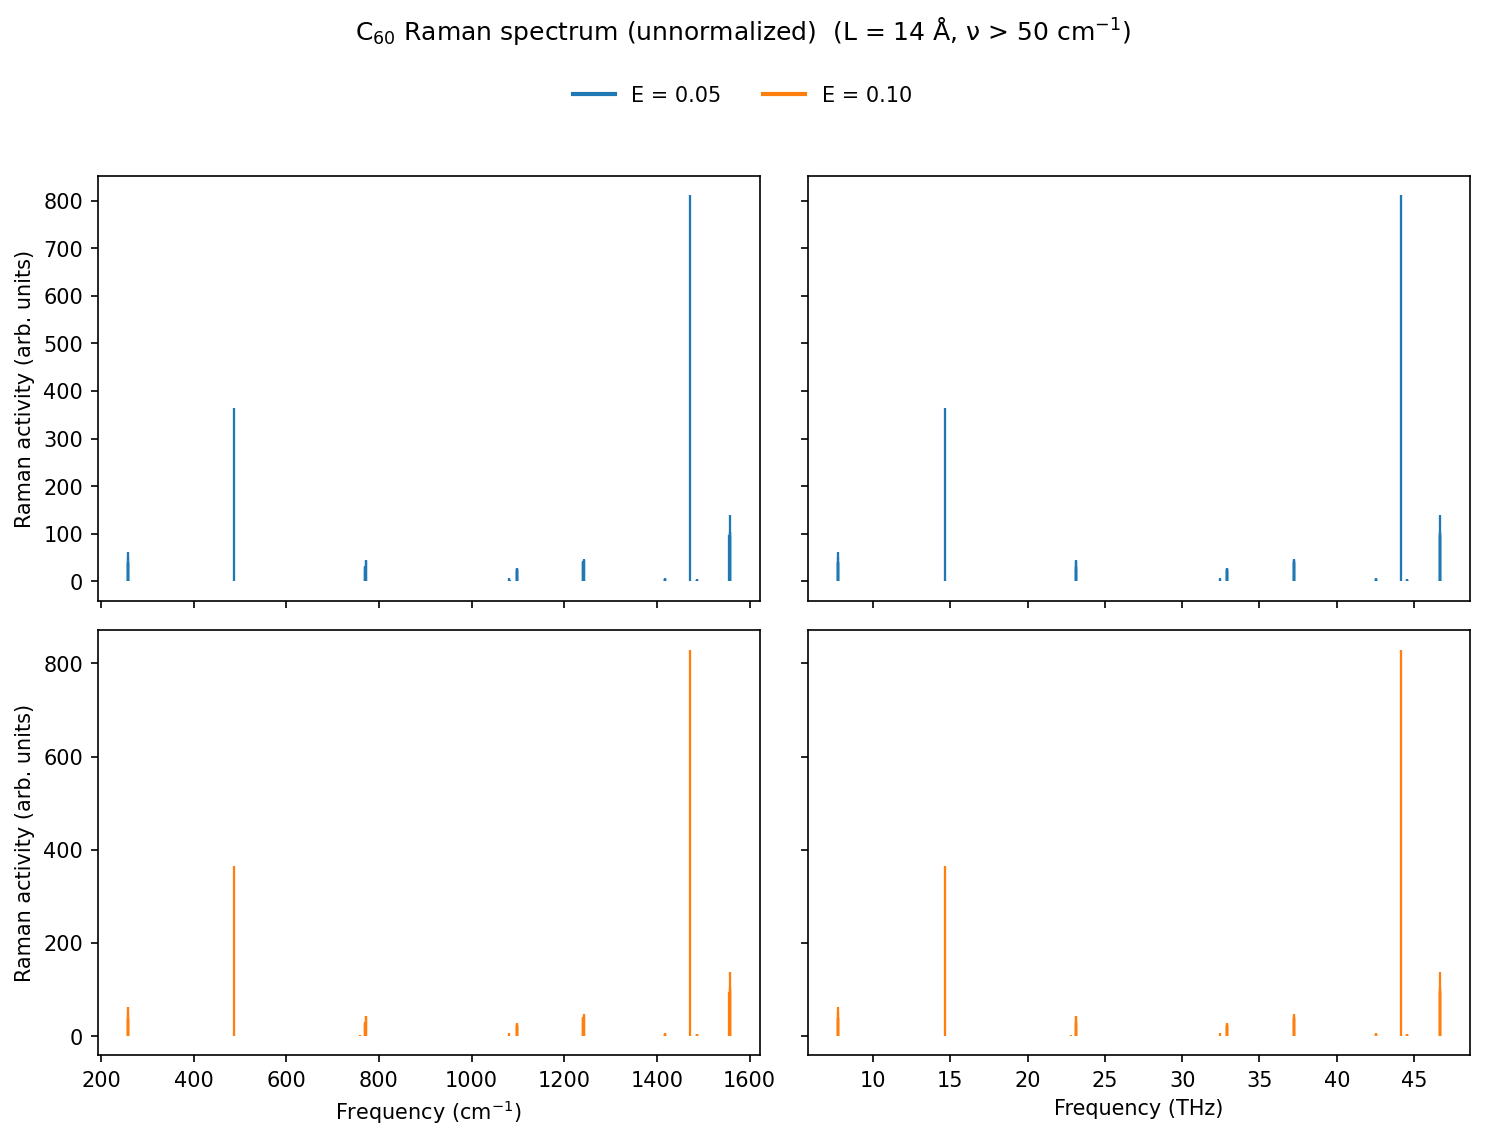

Saved: ../plots/raman_2x2_unnormalized.png


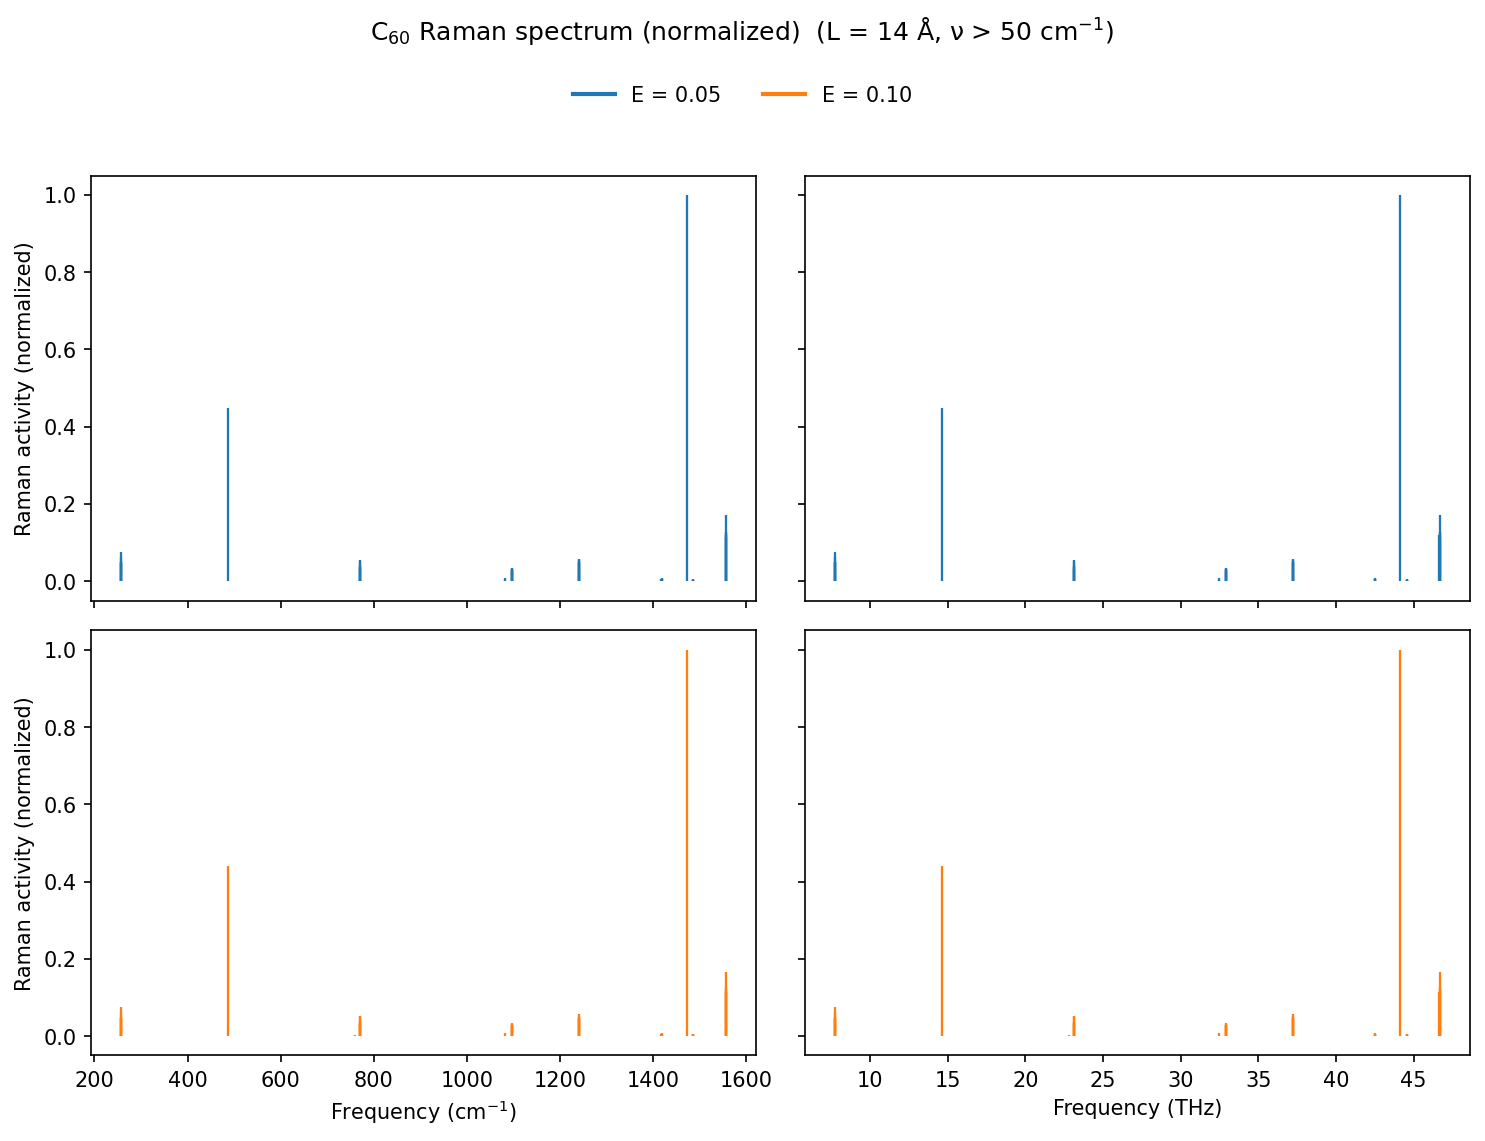

Saved: ../plots/raman_2x2_normalized.png


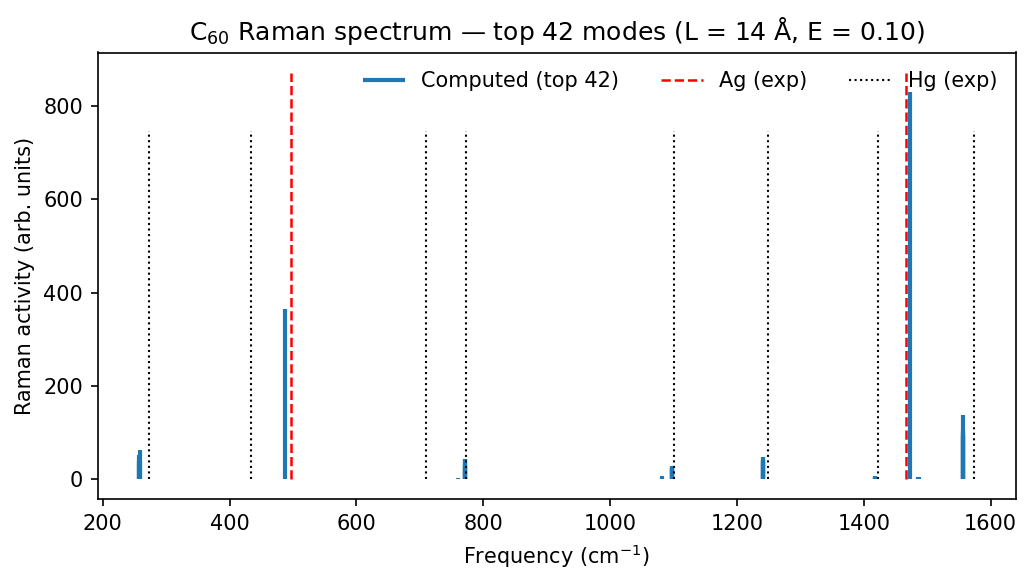

Saved: ../plots/raman_activity_comparison_E0.1_top42.pdf
Saved: ../plots/raman_activity_comparison_E0.1_top42.png


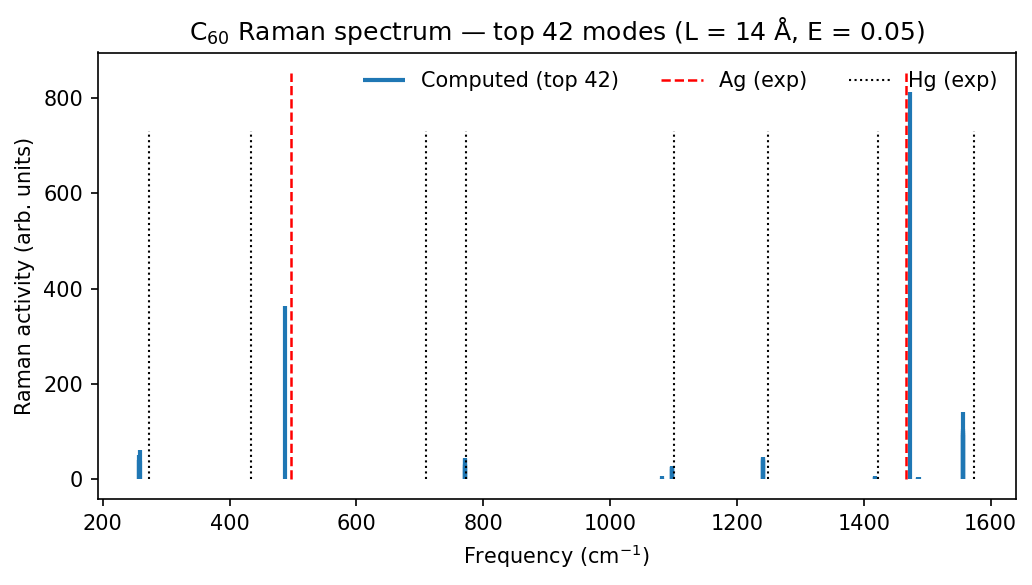

Saved: ../plots/raman_activity_comparison_E0.05_top42.pdf
Saved: ../plots/raman_activity_comparison_E0.05_top42.png


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

# =========================================
# Raman plotting + experimental comparison
# =========================================
# Expected merged file format (whitespace-delimited) with a header row:
# mode  freq_THz  freq_cm-1  activity_E0.05  activity_E0.1
#
# This code reads the header safely (pandas), avoiding np.loadtxt failure.
#
# Experimental Raman mode references (Ag/Hg) are taken from:
# https://pmc.ncbi.nlm.nih.gov/articles/PMC11820995/
# (see discussion of Raman-active vibrational modes and reported peak positions)
# =========================================

# -------------------------
# Paths
# -------------------------
DATA_FILE = Path("../data/processed/raman_phonopy_E0.05_E0.1.dat")
PLOTS_DIR = Path("../plots")
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

if not DATA_FILE.exists():
    raise FileNotFoundError(f"Missing file: {DATA_FILE}")

# -------------------------
# Load merged data (header-safe)
# -------------------------
df = pd.read_csv(DATA_FILE, delim_whitespace=True)

required_cols = ["mode", "freq_THz", "freq_cm-1", "activity_E0.05", "activity_E0.1"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError("Missing required columns:\n" + "\n".join(missing))

mode  = df["mode"].to_numpy(dtype=int)
f_THz = df["freq_THz"].to_numpy(dtype=float)
f_cm  = df["freq_cm-1"].to_numpy(dtype=float)
R05   = df["activity_E0.05"].to_numpy(dtype=float)
R10   = df["activity_E0.1"].to_numpy(dtype=float)

# -------------------------
# Basic numeric checks
# -------------------------
for name, arr in [("freq_THz", f_THz), ("freq_cm-1", f_cm), ("R05", R05), ("R10", R10)]:
    if not np.isfinite(arr).all():
        raise ValueError(f"Non-finite values detected in {name}")

# -------------------------
# Filter near-zero modes (plotting only)
# -------------------------
cm_cut = 50.0
mask = f_cm > cm_cut
mode, f_THz, f_cm, R05, R10 = mode[mask], f_THz[mask], f_cm[mask], R05[mask], R10[mask]

# -------------------------
# Consistent colors
# -------------------------
c05 = "tab:blue"
c10 = "tab:orange"

# =========================================
# 2x2 plot helper (vlines) for cm^-1 and THz
# =========================================
def plot_2x2(R05_plot, R10_plot, ylabel, title, fname_png):
    fig, axes = plt.subplots(
        2, 2, figsize=(10, 7), dpi=150,
        sharex="col",
        sharey="row"
    )

    # E = 0.05
    axes[0,0].vlines(f_cm,  0, R05_plot, color=c05, lw=1.1)
    axes[0,1].vlines(f_THz, 0, R05_plot, color=c05, lw=1.1)

    # E = 0.10
    axes[1,0].vlines(f_cm,  0, R10_plot, color=c10, lw=1.1)
    axes[1,1].vlines(f_THz, 0, R10_plot, color=c10, lw=1.1)

    # Labels
    axes[0,0].set_ylabel(ylabel)
    axes[1,0].set_ylabel(ylabel)
    axes[1,0].set_xlabel("Frequency (cm$^{-1}$)")
    axes[1,1].set_xlabel("Frequency (THz)")

    # Common legend
    legend_lines = [
        plt.Line2D([0], [0], color=c05, lw=2),
        plt.Line2D([0], [0], color=c10, lw=2),
    ]
    legend_labels = ["E = 0.05", "E = 0.10"]

    fig.legend(
        legend_lines,
        legend_labels,
        loc="upper center",
        ncol=2,
        frameon=False,
        bbox_to_anchor=(0.5, 1.03),
    )

    fig.suptitle(f"{title}  (L = 14 Å, ν > {cm_cut:.0f} cm$^{{-1}}$)", y=1.08)

    plt.tight_layout()

    out_png = PLOTS_DIR / fname_png
    fig.savefig(out_png, dpi=250, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

# -------------------------
# Figure 1: Unnormalized 2x2
# -------------------------
plot_2x2(
    R05, R10,
    ylabel="Raman activity (arb. units)",
    title="C$_{60}$ Raman spectrum (unnormalized)",
    fname_png="raman_2x2_unnormalized.png",
)

# -------------------------
# Figure 2: Normalized 2x2 (per-field normalization)
# -------------------------
R05n = R05 / R05.max() if R05.max() > 0 else R05
R10n = R10 / R10.max() if R10.max() > 0 else R10

plot_2x2(
    R05n, R10n,
    ylabel="Raman activity (normalized)",
    title="C$_{60}$ Raman spectrum (normalized)",
    fname_png="raman_2x2_normalized.png",
)

# =========================================
# Experimental comparison plots (cm^-1 only)
# =========================================
# Experimental reference (cm^-1)
exp_Ag = [497, 1467]
exp_Hg = [273, 433, 709, 772, 1100, 1249, 1422, 1574]

def plot_top_peaks_vs_experiment(f_cm, intens, top_n, title, fname_base):
    # Select top peaks by intensity and sort by frequency
    idx = np.argsort(intens)[-top_n:]
    idx = idx[np.argsort(f_cm[idx])]

    ymax = float(intens[idx].max()) if intens[idx].size > 0 else 1.0

    plt.figure(figsize=(7,4), dpi=150)

    plt.vlines(f_cm[idx], 0, intens[idx], color="C0", lw=2, label=f"Computed (top {top_n})")
    plt.vlines(exp_Ag, 0, ymax*1.05, color="red",   ls="--", lw=1.2, label="Ag (exp)")
    plt.vlines(exp_Hg, 0, ymax*0.90, color="black", ls=":",  lw=1.0, label="Hg (exp)")

    plt.xlabel("Frequency (cm$^{-1}$)")
    plt.ylabel("Raman activity (arb. units)")
    plt.title(title)
    plt.legend(ncol=3, frameon=False)
    plt.tight_layout()

    out_pdf = PLOTS_DIR / f"{fname_base}.pdf"
    out_png = PLOTS_DIR / f"{fname_base}.png"
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.savefig(out_png, dpi=250, bbox_inches="tight")
    plt.show()

    print("Saved:", out_pdf)
    print("Saved:", out_png)
    return idx

TOP_N = 42

# E = 0.10 comparison
idx10 = plot_top_peaks_vs_experiment(
    f_cm=f_cm,
    intens=R10,
    top_n=TOP_N,
    title="C$_{60}$ Raman spectrum — top 42 modes (L = 14 Å, E = 0.10)",
    fname_base="raman_activity_comparison_E0.1_top42",
)

# E = 0.05 comparison
idx05 = plot_top_peaks_vs_experiment(
    f_cm=f_cm,
    intens=R05,
    top_n=TOP_N,
    title="C$_{60}$ Raman spectrum — top 42 modes (L = 14 Å, E = 0.05)",
    fname_base="raman_activity_comparison_E0.05_top42",
)

# Optional: print selected peak lists
# print("\nTop peaks (E0.1) — mode, freq(cm-1), activity:")
# for i in idx10:
#     print(f"{mode[i]:3d}  {f_cm[i]:9.3f}  {R10[i]:.6e}")

# print("\nTop peaks (E0.05) — mode, freq(cm-1), activity:")
# for i in idx05:
#     print(f"{mode[i]:3d}  {f_cm[i]:9.3f}  {R05[i]:.6e}")
